# General

> https://www.kaggle.com/rhammell/ships-in-satellite-imagery

***Aim***: detect the location of large ships in satellite images

***Motivation***: automating this process can be applied to many issues (e.g., monitoring port activity levels, supply chain analysis)

# Dataset:

- 2800 labeled 80x80 RGB images from the San Francisco Bay area, released as part of Planet’s Open California Dataset. Posted on Kaggle. 

image chips extracted from Planet satellite imagery collected over San Francisco Bay and San Pedro Bay areas of California
- 4000 80x80 RGB images labeled either a "ship" or "no-ship" classification
- image chips were derived from PlanetScope full-frame visual scene products, which are orthorectified to a 3 meter pixel size

##### shipsnet.zip
- contains the entire dataset as .png image chips
- each individual filename follows a specific format:{label}_{scene id}_{longitude}_{latitude}.png
     - ***label***: Valued 1 ("ship") or 0 ("no-ship")
     - ***scene id***: The unique identifier of the PlanetScope visual scene the image chip was extracted from. The scene id can be used with the Planet API (link on Kaggle page) to discover and download the entire scene
     - **longitude_latitude***: The long and lat coordinates of the image center point, with values separated by a single underscore


##### JSON
- The datasest is also distributed as a JSON formatted text file shipsnet.json
    - the loaded object contains ***data***, ***label***, ***scene_ids***, and ***location lists***
    

- pixel value data for each 80x80RGB image is stored as a list of 19200 integers within the ***data*** list
    - the first 6400 entries contain the red channel values, the next 6400 the green, and the final 6400 the blue
    - The image is stored in row-major order, so that the first 80 entries of the array are the red channel values of the first row of the image

- the list values at index *i* in ***labels***, ***scene_ids***, and ***locations*** each correspond to the *i*-th image in the ***data*** list. 

##### Class Labels
- "ship" class includes 1000 images
    - near-centered on the body of a single ship
    - includes ships of dif sizes, orientations, atmospheric collection conditions
- "no-ship" class includes 3000 images
    - 1/3 are random sampling of dif landcover features (water, vegetation, bare earth, buildings, etc.) that do not include any portion of a ship
    - 1/3 are "partial ships" (contain only a portion of a ship, but not enough to meet the full definition of the "ship" class
    - 1/3 are images that have previously been mislabeled by machine learning models, typically caused by bright pixels or strong linear features

# Part I (MM): Test typical suite of classification algorithms on the dataset

Classification algorithms:
- logistic regression
- k-nearest neighbors (Knn)
- support vector classifiers (SVC)
- various decision trees
These classifiers "learn" to recognize an image by taking in a vectorized version of the pixel values, and then grouping the images by similarities. 


Dataset
- The original images are a 3-dimensional array (80 pixels x 80 pixels, with 3-RGB color channels)
- Each pixel for each RGB channel has a value between 0 and 255
- Once vectorized, the image is essentially a list of 19200 (80x80x3) numbers that you can feed into a model for training. 


- In addition to the original thumbnails, I also flipped/rotated a subset of the images to create an additional 1000 images for training

# Part II (MM): Neural Nets


***Classification vs. localization vs. object detection***

- Image Classification: Given an image of a single object, can the algorithm identify the object?
- Classification with localization: Can the algorithm place a bounding box around a single object?
- Detection: Can the algorithm detect multiple objects and place bounding boxes around each one?


The initial classification algorithms discussed above (e.g. logistic regression) focused on image classification- given a thumbnail, can I classify the object as a ship or non-ship? However, the goal of this project wasn’t to identify whether a given thumbnail contained a ship or not, the goal was object detection- finding multiple ships within a much larger satellite image scene.


### 1. Train an improved classification algorithm on the thumbnails, with a lower false positive rate than the above typical classification algorithms

### 2. Object Detection & Sliding Windows
- use sliding windows for object detection; rectangular window moves across an image and applies a classifier model to each region to determine if the given region of the image contains a ship

In [1]:
import json, sys, random
import numpy as np
import pandas as pd

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
import keras.callbacks
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
from PIL import Image, ImageDraw

In [4]:
import matplotlib.pyplot as plt

In [ ]:
keras.__version__

### Download and study the dataset

In [5]:
f = open(r'/Users/laurenfinkelstein/Metis/Projects/project_5/data/shipsnet.json')
dataset = json.load(f)
f.close()

In [6]:
# to get a better idea of what's in the json file

df = pd.read_json('/Users/laurenfinkelstein/Metis/Projects/project_5/data/shipsnet.json')
df.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [7]:
# note: unit8 = Unsigned integer (0 to 255)

input_data = np.array(dataset['data']).astype('uint8')
output_data = np.array(dataset['labels']).astype('uint8')

**INPUT**

The dataset contains 4000 images. One image is represented as a vector of length 19200.   
- (image size = 80x80 = 6400) * 3 RGB bands

In [8]:
input_data.shape

(4000, 19200)

In [9]:
input_data[1].shape

(19200,)

In [10]:
# what do the tuples of arrays look like?
input_data

array([[ 82,  89,  91, ...,  86,  88,  89],
       [ 76,  75,  67, ...,  54,  57,  58],
       [125, 127, 129, ..., 111, 109, 115],
       ...,
       [171, 135, 118, ...,  95,  95,  85],
       [ 85,  90,  94, ...,  96,  95,  89],
       [122, 122, 126, ...,  51,  46,  69]], dtype=uint8)

We can see that this is not a photo format that we can visualize. In order to read an image, we need to reshape the array/input_data. 

In [11]:
n_spectrum = 3 # the number of color chanels: RGB 
weight = 80
height = 80
X = input_data.reshape([-1, n_spectrum, weight, height])
X[0].shape

(3, 80, 80)

In [12]:
# get one channel 
pic = X[3]

red_spectrum = pic[0]
green_spectrum = pic[1]
blue_spectrum = pic[2]

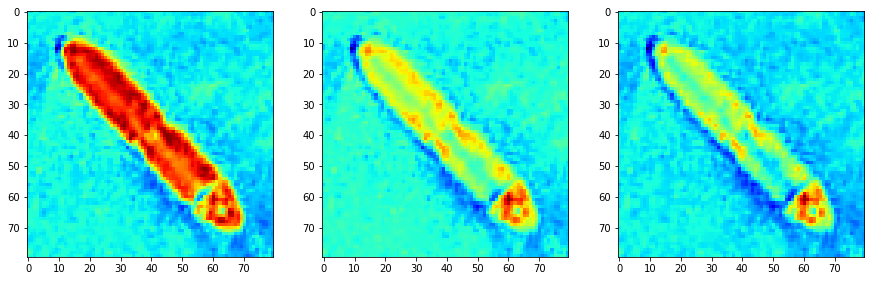

In [13]:
## plot the photo on all 3 channels

plt.figure(2, figsize = (5*3, 5*1))
plt.set_cmap('jet')

# show each channel
plt.subplot(1, 3, 1)
plt.imshow(red_spectrum)

plt.subplot(1, 3, 2)
plt.imshow(green_spectrum)

plt.subplot(1, 3, 3)
plt.imshow(blue_spectrum)

plt.show()

# note: some of the photos (e.g., X[0]) might not have 3 RGB bands (e.g., may have the same 3 RGB bands) and you only get 1 color;
# if that's the case, try another one (e.g., X[3])

**OUTPUT**

The output is a vector of length 4000 elements. 

In [14]:
output_data.shape

(4000,)

The vector contains int 0 ("no ship") and 1 ("ship"). 

In [15]:
output_data

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

The vector contains 3000 zeros and 1000 units (i.e., 1000 images tagged with "ship" and 3000 images with "no-ship"). 

In [16]:
np.bincount(output_data)

array([3000, 1000])

# Preparing the data

Categorically encode the labels. The below converts a class vector (integers) (where class vector = output_data) to a binary class matrix (where num class = 2). 


In [17]:
# output encoding
y = np_utils.to_categorical(output_data, 2)

In [18]:
# reshape the image data
X = X.transpose([0,2,3,1])

The original images are a 3D array (80 pixels x 80 pixels, with 3-RGB color channels), and each pixel for each RGB channel has a value between 0 and 255. We would like to constrain values between 0 and 1. 

In [19]:
# normalization
X = X / 255

In [20]:
type(X)

numpy.ndarray

In [21]:
X[1].shape

(80, 80, 3)

### Create transformations of images (MM)

Make a rotated set of data

In [22]:
datagen = ImageDataGenerator(
        rotation_range=90, # rotate 90 degrees
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True # randomly flip images vertically
)

datagen.fit(X)

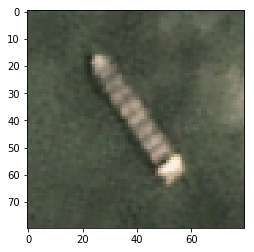

In [23]:
# show 1 image
plt.imshow(X[1])

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


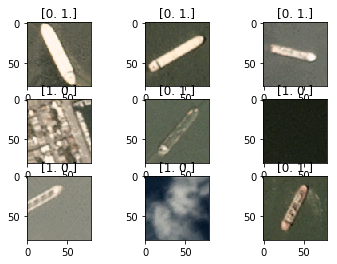

In [24]:
# transform 1000 images to increase input data

for X_batch, y_batch in datagen.flow(X, y, batch_size=1000, shuffle = True):
#   Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
        plt.title(y_batch[i])
    # show the plot
    plt.show()
    break

In [25]:
# concatenate original image dataset with additional rotated images

X_rot = np.concatenate((X,X_batch))
y_rot = np.concatenate((y,y_batch))

In [26]:
X_rot.shape

(5000, 80, 80, 3)

In [27]:
y_rot.shape

(5000, 2)

Shuffle the data before modeling

In [31]:
# shuffle all indexes
indexes = np.arange(5000)
np.random.shuffle(indexes)

In [33]:
# shuffle X and y data

X_train = X_rot[indexes]
y_train = y_rot[indexes]

In [34]:
X_train.shape

(5000, 80, 80, 3)

In [35]:
y_train.shape

(5000, 2)

### Training the model / Neural Network

In [36]:
np.random.seed(42)

Notes from https://danielmoraite.github.io/docs/fifth.html:

The “layer” is a data-processing module which can be conceived as a “filter” for data. Layers extract representations out of the data fed into them. Deep learning could mainly consist of chaining together simple layers which will implement a form of progressive “data distillation”. A deep learning model is made of a succession of increasingly refined data filters which are the “layers”.

In [37]:
# network design
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Dropout(0.25))

model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Notes from https://danielmoraite.github.io/docs/fifth.html:

- An **optimizer**: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
- **Metrics** to monitor during training and testing. Will be interested only in the fraction of the images that were correctly classified: ‘accuracy’.
- **Loss function**: this is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.

In [38]:
# optimization setup
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(
  loss='categorical_crossentropy',
  optimizer=sgd,
  metrics=['accuracy'])

# training
model.fit(
  X_train, 
  y_train,
  batch_size=32, # 32 photos at once
  epochs=18,
  validation_split=0.2,
  shuffle=True,
  verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 4000 samples, validate on 1000 samples
Epoch 1/18
 - 73s - loss: 0.3914 - acc: 0.8303 - val_loss: 0.1990 - val_acc: 0.9070
Epoch 2/18
 - 58s - loss: 0.2332 - acc: 0.9012 - val_loss: 0.1841 - val_acc: 0.9350
Epoch 3/18
 - 66s - loss: 0.2056 - acc: 0.9188 - val_loss: 0.1216 - val_acc: 0.9580
Epoch 4/18
 - 73s - loss: 0.1660 - acc: 0.9308 - val_loss: 0.1413 - val_acc: 0.9490
Epoch 5/18
 - 64s - loss: 0.1424 - acc: 0.9465 - val_loss: 0.1296 - val_acc: 0.9590
Epoch 6/18
 - 57s - loss: 0.1212 - acc: 0.9560 - val_loss: 0.0695 - val_acc: 0.9750
Epoch 7/18
 - 51s - loss: 0.1320 - acc: 0.9507 - val_loss: 0.0695 - val_acc: 0.9800
Epoch 8/18
 - 48s - loss: 0.1028 - acc: 0.9625 - val_loss: 0.0582 - val_acc: 0.9820
Epoch 9/18
 - 63s - loss: 0.0998 - acc: 0.9650 - val_loss: 0.0712 - val_acc: 0.9790
Epoch 10/18
 - 54s - loss: 0.0884 - acc: 0.9635 - val_loss: 0.0418 - val_acc: 0.9860
Epoch 11/18
 - 53s - loss: 0.0787 - acc: 0.9710 - val_loss: 0.0

Displayed above during training are the “loss” of the network and the accuracy of the network over the training data. We get an accuracy of 0.9972 (i.e. 99.72%) on the training data.

### Using the Network

Download an image

In [39]:
image = Image.open(r'/Users/laurenfinkelstein/Metis/Projects/project_5/data/scenes/sfbay_1.png')
pix = image.load()

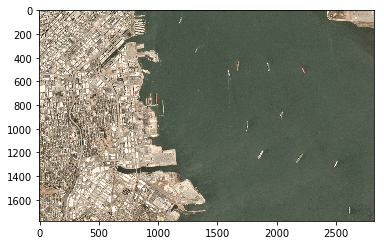

In [40]:
# for a quick look at the image
plt.imshow(image)

In [41]:
n_spectrum = 3
width = image.size[0]
height = image.size[1]

In order to make use of the image, we need to create a vector. 

In [45]:
# create vector
picture_vector = []
for chanel in range(n_spectrum):
  for y in range(height):
      for x in range(width):
          picture_vector.append(pix[x, y][chanel])

In [49]:
picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)

In [52]:
picture_vector

array([221, 235, 217, ...,  84,  80,  79], dtype=uint8)

In [56]:
picture_tensor[0]

array([[221, 205, 181],
       [235, 218, 198],
       [217, 203, 184],
       ...,
       [187, 168, 148],
       [187, 167, 145],
       [173, 153, 129]], dtype=uint8)

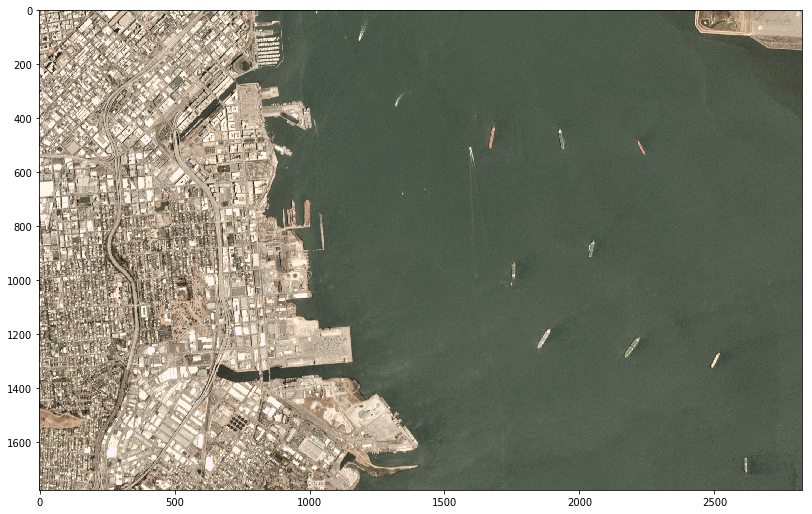

In [57]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3, 1, 1)
plt.imshow(picture_tensor)

plt.show()

In [59]:
# reshape picture_tensor to (n_spectrum, height, width)

picture_tensor = picture_tensor.transpose(2,0,1)

Search on the image

In [62]:
# creating window ??

def cutting(x, y):
  area_study = np.arange(3*80*80).reshape(3, 80, 80)
  for i in range(80):
      for j in range(80):
          area_study[0][i][j] = picture_tensor[0][y+i][x+j]
          area_study[1][i][j] = picture_tensor[1][y+i][x+j]
          area_study[2][i][j] = picture_tensor[2][y+i][x+j]
  area_study = area_study.reshape([-1, 3, 80, 80])
  area_study = area_study.transpose([0,2,3,1])
  area_study = area_study / 255
  sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
  return area_study

In [ ]:
# ?? 

def not_near(x, y, s, coordinates):
  result = True
  for e in coordinates:
      if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
          result = False
  return result

In [ ]:
# ??

def show_ship(x, y, acc, thickness=5):   
  for i in range(80):
      for ch in range(3):
          for th in range(thickness):
              picture_tensor[ch][y+i][x-th] = -1
  for i in range(80):
      for ch in range(3):
          for th in range(thickness):
              picture_tensor[ch][y+i][x+th+80] = -1
  for i in range(80):
      for ch in range(3):
          for th in range(thickness):
              picture_tensor[ch][y-th][x+i] = -1
  for i in range(80):
      for ch in range(3):
          for th in range(thickness):
              picture_tensor[ch][y+th+80][x+i] = -1

In [ ]:
# Note: can adjust number of steps (but may take a while)

step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
  for x in range(int((width-(80-step))/step)):
      area = cutting(x*step, y*step)
      result = model.predict(area)
      if result[0][1] > 0.90 and not_near(x*step,y*step, 88, coordinates):
          coordinates.append([[x*step, y*step], result])
          print(result)
          plt.imshow(area[0])
          plt.show()

We can see that it did classify images that have straight lines and bright pixels as ships. Next step: polish the model. 

Make sense of tags and find them on the image

In [ ]:
# for a better understanding, let's tag the findings on the image

for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])

In [ ]:
# picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape

In [ ]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()